# pySCENIC protocol: sunhye 2nd experiment

June 2020

Dataset: 2nd experiment from SHL

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [3]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

#### set variables for file paths to read from and write to:

In [4]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj'

In [205]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
loom_file = 'output/scenic/allfeatures_only_pt_seu-final.loom'

adata_file = loom_file.replace("-final.loom", ".h5ad")
# adata_file = 'output/scenic/allfeatures_only_pt_w_ctrl_seu.h5ad'



In [206]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
MulticoreTSNE       NA
PIL                 7.2.0
adjustText          NA
anndata             0.7.4
attr                20.2.0
backcall            0.2.0
boltons             NA
cairo               1.19.1
cffi                1.11.5
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.1
dask                1.0.0
dateutil            2.8.1
decorator           4.4.2
frozendict          NA
get_version         2.1
h5py                2.10.0
idna                2.10
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.0
ipython_genutils    0.2.0
jedi                0.17.1
jinja2              2.11.2
joblib              0.16.0
jsonschema          3.2.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.33.0+1.g022ab0f
loompy              3.0.6
louvain             0.6.1
markupsafe          1.1.1
matplotlib          3.3.1
mkl                 2.3

## Extract relevant data from the integrated loom file

In [207]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [208]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [209]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [210]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [211]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [212]:
regulons.keys()

dict_keys(['ATF4_(+)', 'ATF6_(+)', 'CEBPG_(+)', 'HES6_(+)', 'HMGN3_(+)', 'JUND_(+)', 'KDM5B_(+)', 'MYCN_(+)', 'NFE2L2_(+)', 'NR2F6_(+)', 'NRL_(+)', 'RAX_(+)', 'RORA_(+)', 'ZNF639_(+)'])

In [213]:
myregulon = 'NRL_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 14 genes in NRL_(+).'

## distribution of number of genes per regulon

In [214]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count    14.000000
mean     19.071429
std      25.799416
min       4.000000
25%       5.250000
50%      12.000000
75%      13.500000
max      93.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [215]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [216]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [217]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [218]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Regulons' as categorical


In [219]:
adata_h5ad = sc.read(adata_file)

metadata = adata_h5ad.obs

new_adata_obs = adata.obs.join(metadata, how = "left")

In [220]:
adata_h5ad

AnnData object with n_obs × n_vars = 157 × 56026
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane', 'custom_cluster', 'sample_number', 'sample_id', 'names', 'batch', 'pt1_clusters', 'pt2_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [221]:
adata.obs = new_adata_obs
adata.obs.columns

Index(['ClusterID', 'Clusterings', 'Louvain_clusters_Scanpy', 'Percent_mito',
       'nGene', 'nUMI', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day',
       'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases',
       'lane', 'custom_cluster', 'sample_number', 'sample_id', 'names',
       'batch', 'pt1_clusters', 'pt2_clusters'],
      dtype='object')

In [222]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [223]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [224]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [225]:
# df_motifs = load_motifs('reg.csv')

In [226]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [227]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [228]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


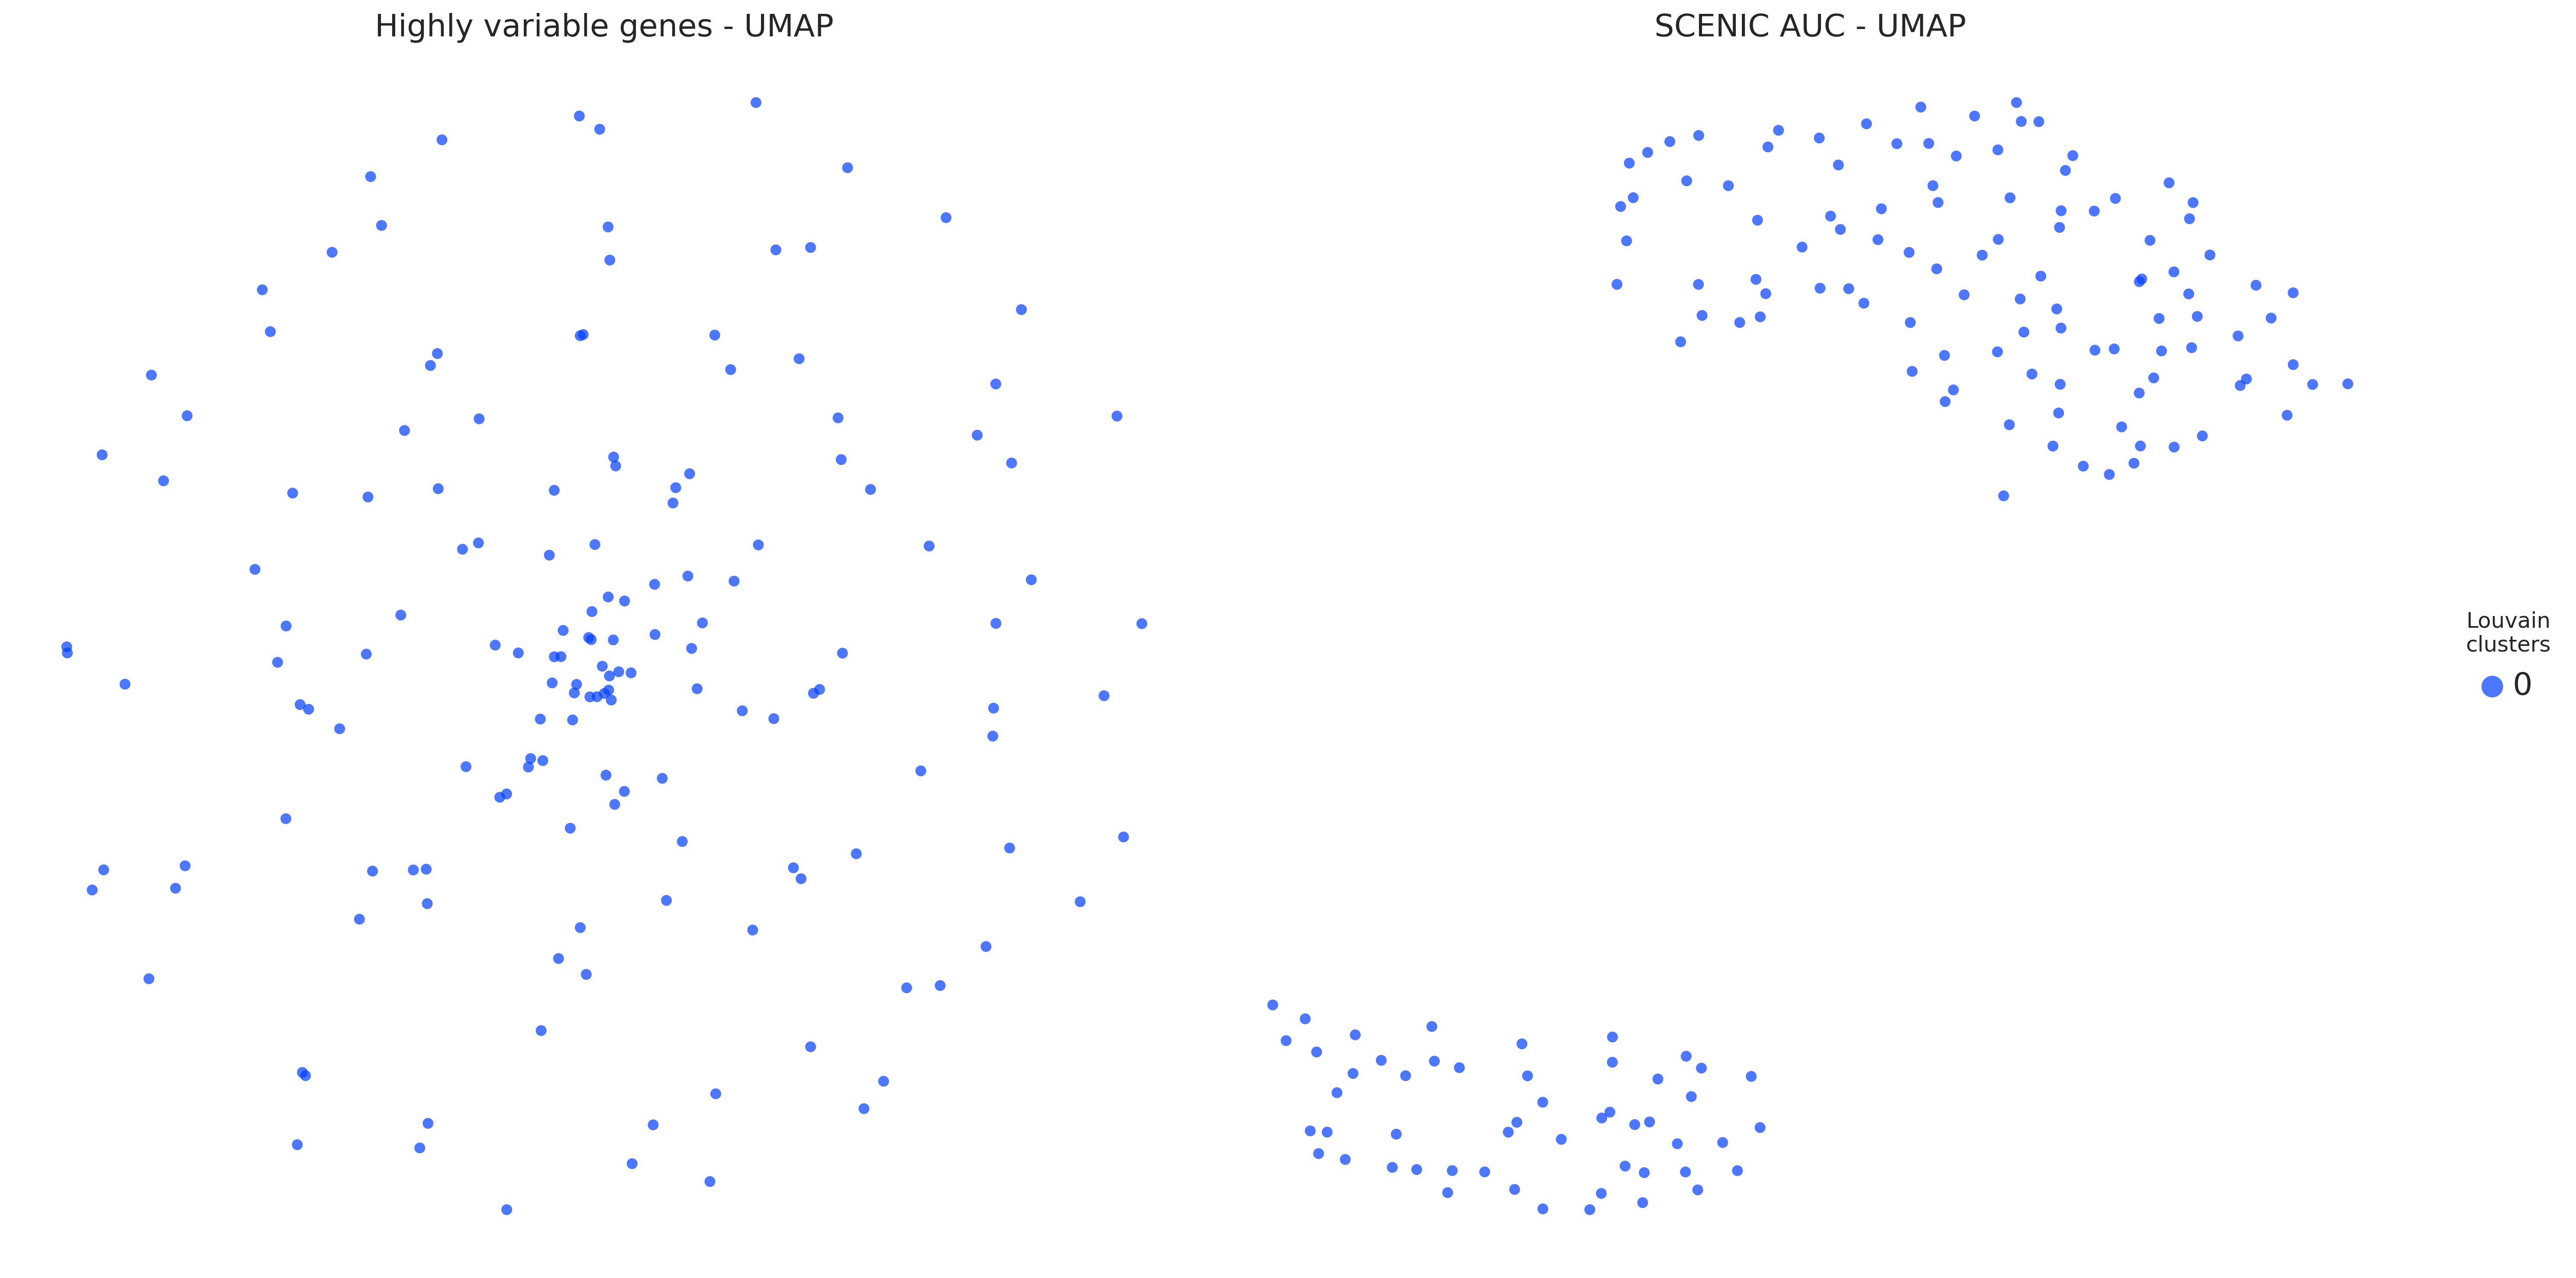

In [229]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [230]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [231]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [346]:
metavar="pt2_clusters"

### Calculate RSS

In [347]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

ATF4_(+)  ATF6_(+)  CEBPG_(+)  HES6_(+)  HMGN3_(+)  JUND_(+)  KDM5B_(+)  \
0   0.201059  0.209075   0.185463  0.205325   0.205727  0.193169   0.202100   
NA  0.503154  0.507066   0.428455  0.464301   0.505041  0.532036   0.519717   
2a  0.209616  0.208426   0.191263  0.206846   0.208879  0.204929   0.206882   
2b  0.291027  0.278533   0.294707  0.289385   0.294945  0.279103   0.288146   
2e  0.270347  0.258917   0.242397  0.246264   0.263841  0.272528   0.270206   
2c  0.333549  0.321062   0.332274  0.327157   0.329688  0.301011   0.317290   
2d  0.278501  0.265101   0.295645  0.294915   0.281266  0.254638   0.276222   

    MYCN_(+)  NFE2L2_(+)  NR2F6_(+)   NRL_(+)   RAX_(+)  RORA_(+)  ZNF639_(+)  
0   0.205971    0.194823   0.200746  0.184776  0.205806  0.205173    0.197694  
NA  0.336398    0.512862   0.514312  0.429456  0.480982  0.476388    0.361642  
2a  0.167445    0.210015   0.210631  0.204585  0.213013  0.217615    0.203621  
2b  0.210422    0.281285   0.284139  0.240356  0.300168  0.287717    0.200052  
2e  0.184196    0.284202   0.275450  0.289816  0.253778  0.240932    0.258221  
2c  0.265400    0.315819   0.324384  0.267387  0.335604  0.340203    0.208160  
2d  0.184377    0.253802   0.268412  0.200202  0.293279  0.283638    0.233251

In [348]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

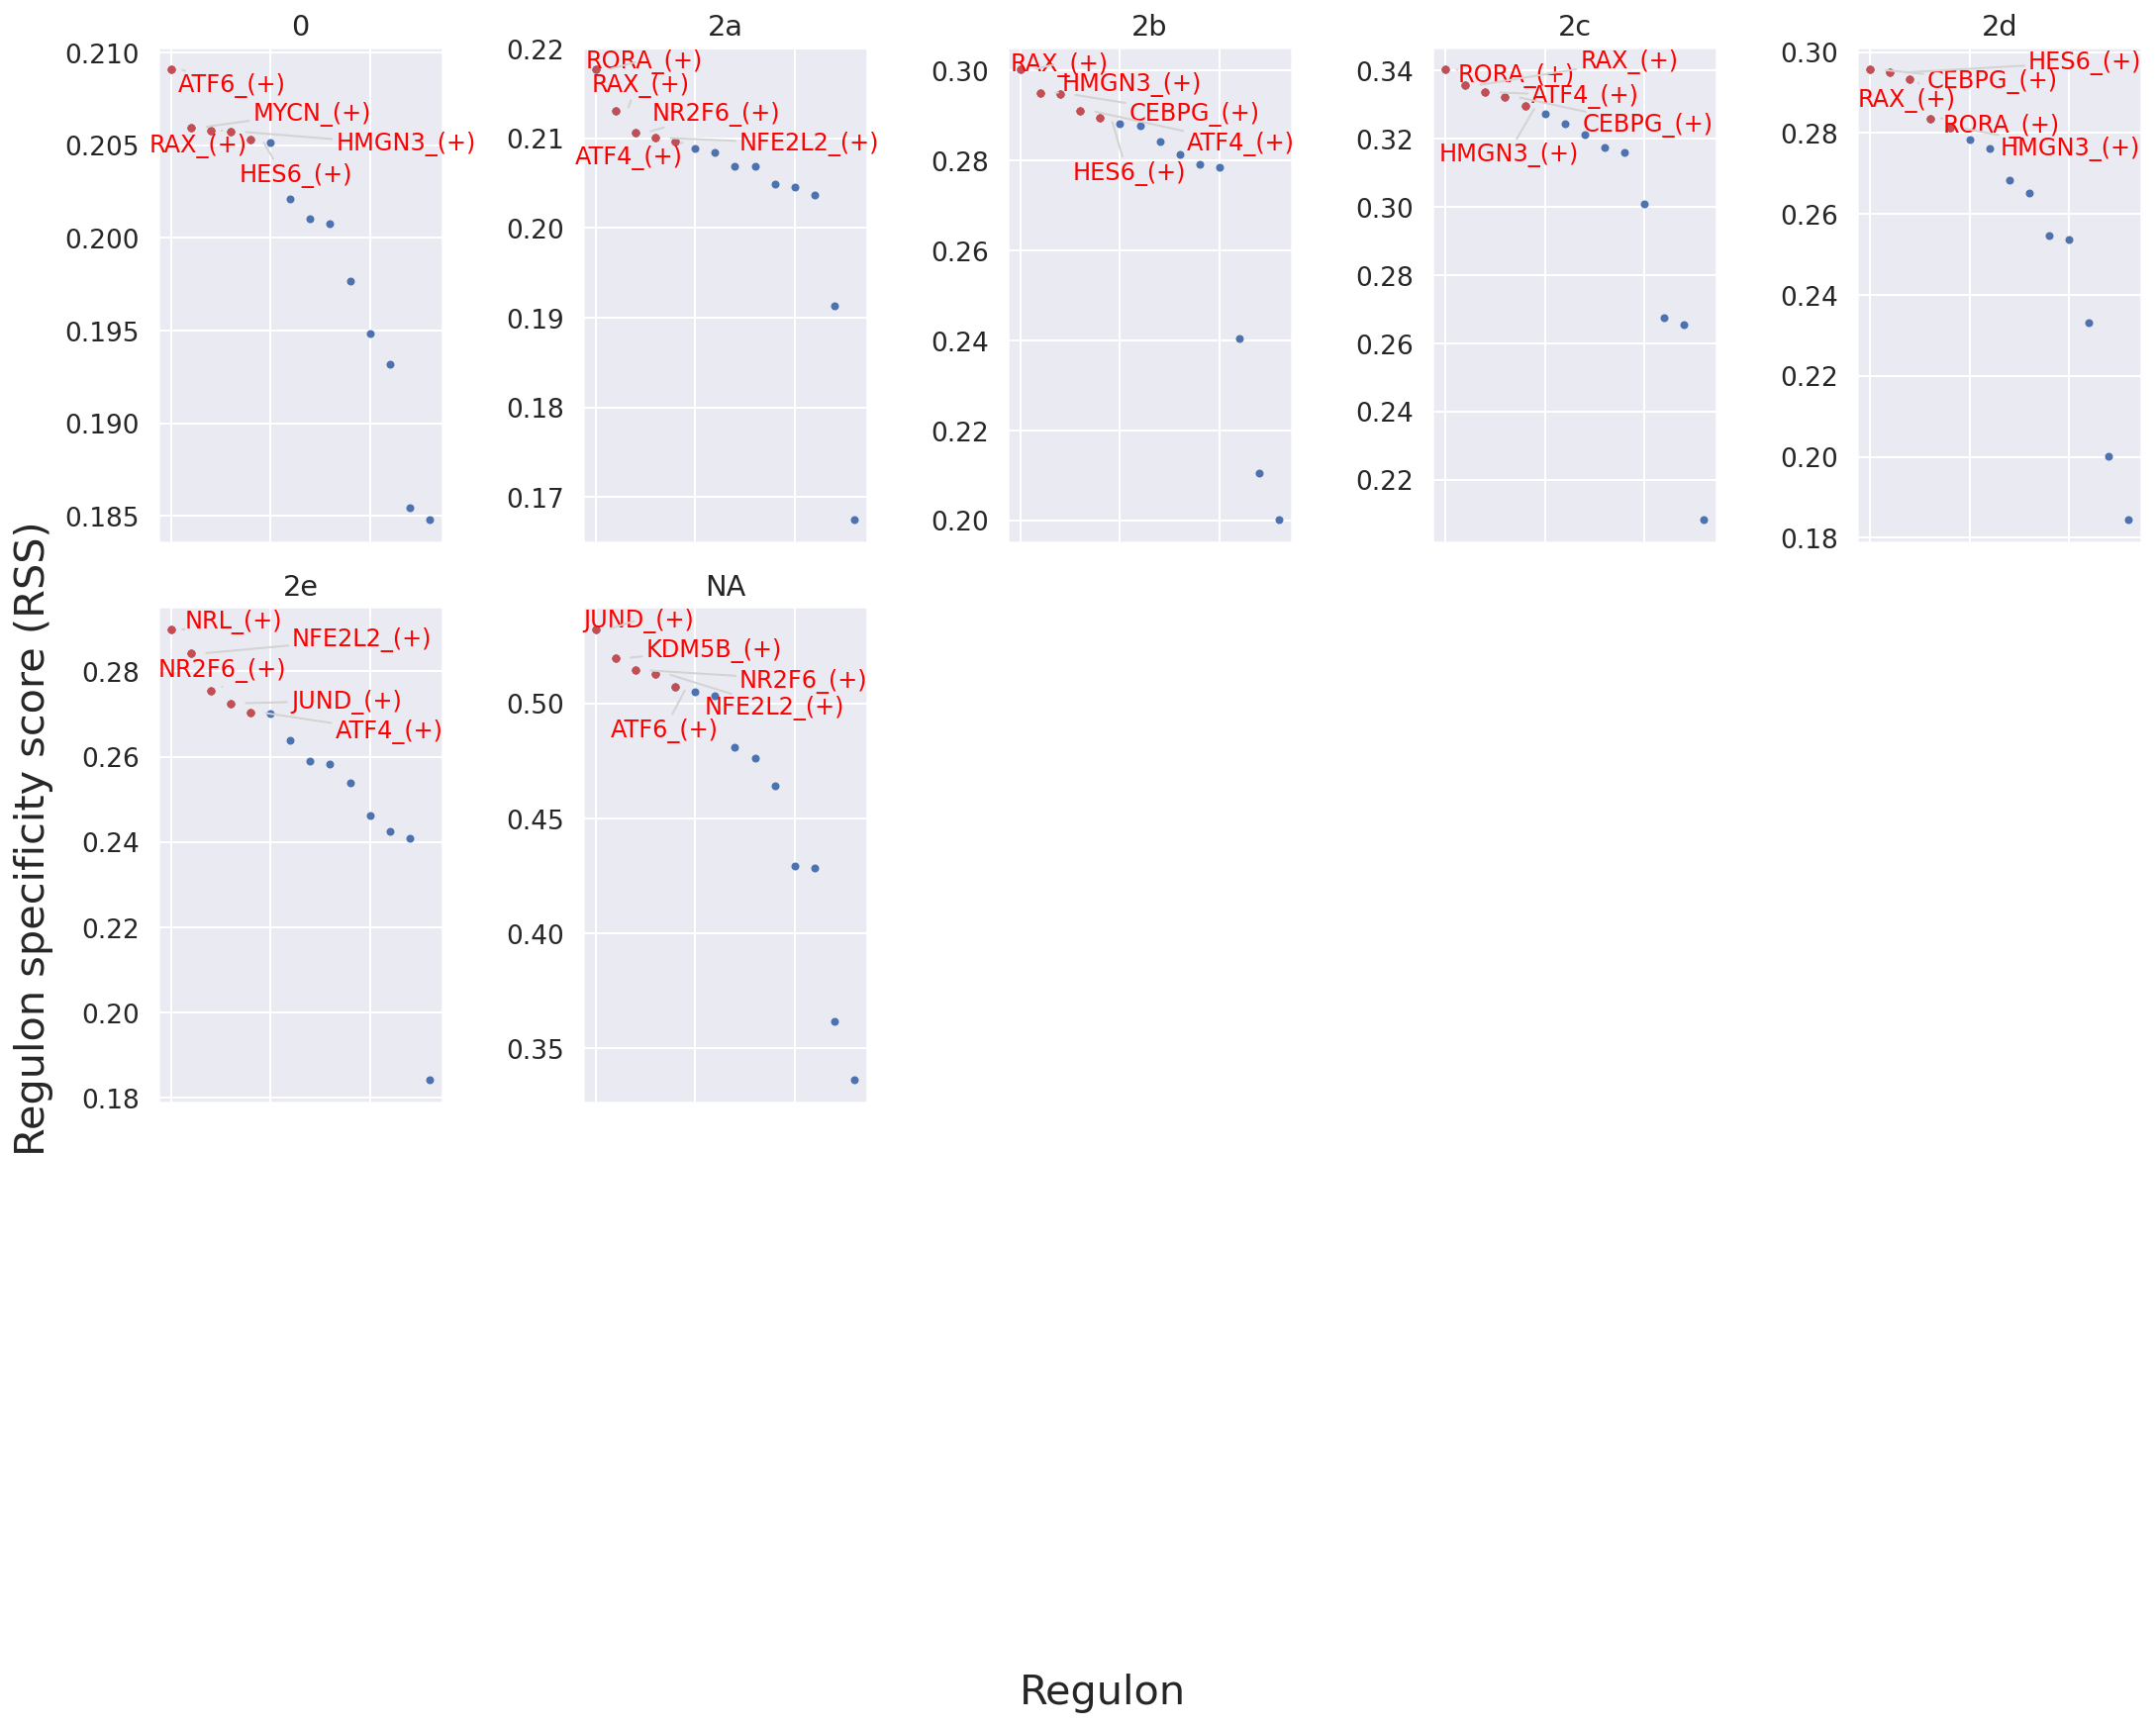

In [349]:
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [350]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [351]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

HMGN3_(+)  MYCN_(+)   NRL_(+)  HES6_(+)  CEBPG_(+)  JUND_(+)  \
pt2_clusters                                                                 
0              0.797731  0.015536  0.068434  0.207339   0.037896  0.065480   
2a             0.705805  0.000000  0.129944  0.175631   0.045450  0.084510   
2b             0.780005  0.006613  0.090021  0.200274   0.086840  0.091252   
2c             0.783371  0.013699  0.100871  0.207802   0.087128  0.083530   
2d             0.797464  0.002116  0.038003  0.239711   0.096370  0.076171   
2e             0.736168  0.003165  0.178512  0.163774   0.065738  0.112669   
NA             0.733063  0.015730  0.138508  0.181066   0.068929  0.115901   

              NFE2L2_(+)  RORA_(+)  ATF4_(+)  NR2F6_(+)  ATF6_(+)  KDM5B_(+)  \
pt2_clusters                                                                   
0               0.202710  0.229081  0.331998   0.213531  0.031923   0.118355   
2a              0.288048  0.261759  0.351806   0.236755  0.025527   0.112661   
2b              0.266052  0.223218  0.366657   0.221634  0.023793   0.122301   
2c              0.274590  0.251809  0.395118   0.241387  0.026776   0.119408   
2d              0.216421  0.238944  0.378181   0.217902  0.024272   0.126643   
2e              0.364548  0.165742  0.391620   0.273678  0.025159   0.134536   
NA              0.302862  0.208862  0.356826   0.243707  0.028415   0.130418   

               RAX_(+)  
pt2_clusters            
0             0.534833  
2a            0.533988  
2b            0.552140  
2c            0.554056  
2d            0.607047  
2e            0.434327  
NA            0.454802

#### Generate a Z-score for each regulon to enable comparison between regulons

In [352]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [353]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [354]:
cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['X46', 'X57', 'X71', 'X78', 'X66', 'X69', 'X64', 'X77', 'X60', 'X72',
       ...
       'X448', 'X451', 'X455', 'X442', 'X550', 'X510', 'X516', 'X549', 'X79',
       'X68'],
      dtype='object', length=157)

In [355]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [356]:
cats

['0', '2a', '2b', '2c', '2d', '2e', 'NA']

In [357]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

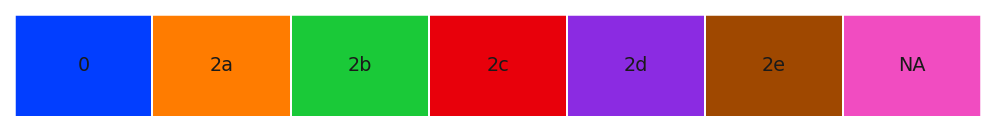

In [358]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Text(0.5, 11.551999999999978, '')

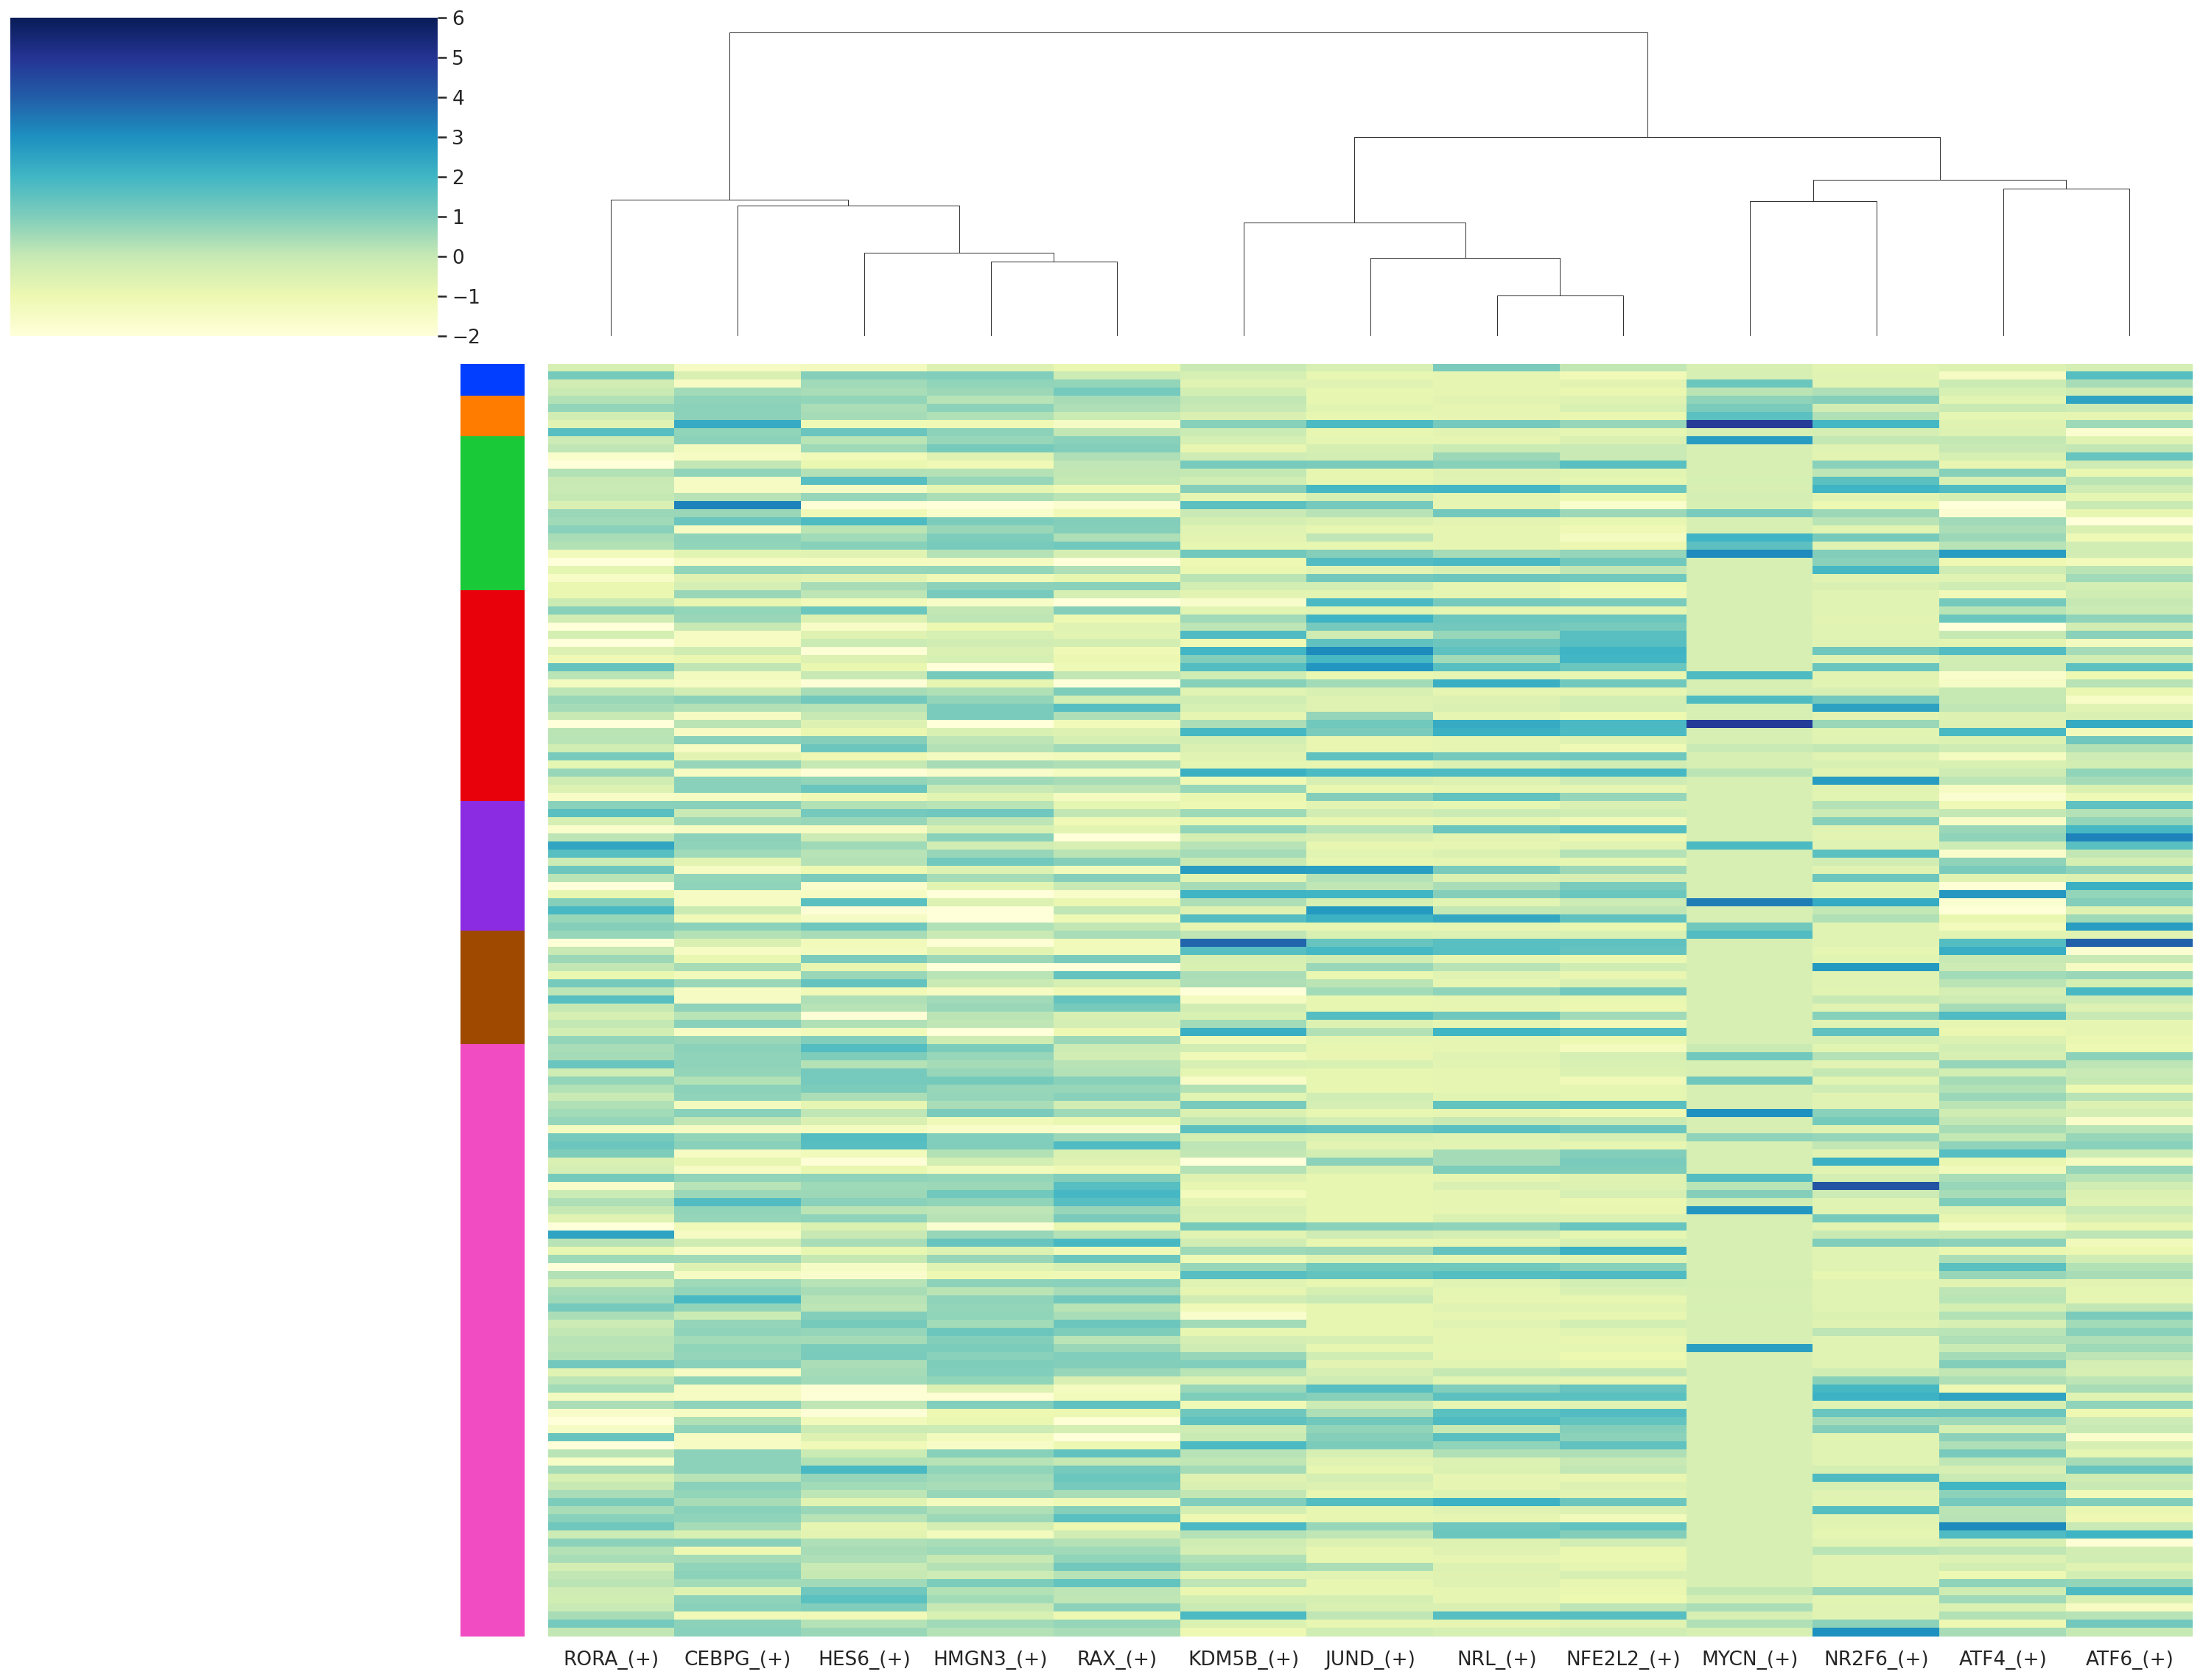

In [359]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [337]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [247]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000016


In [248]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

ATF4_(+)  ATF6_(+)  CEBPG_(+)  HES6_(+)  HMGN3_(+)  JUND_(+)  KDM5B_(+)  \
X46         0         0          0         0          0         0          0   
X57         0         0          0         0          0         0          0   
X71         0         0          0         0          0         0          0   
X78         0         0          1         0          0         0          0   
X60         0         0          0         0          0         0          0   

     MYCN_(+)  NFE2L2_(+)  NR2F6_(+)  NRL_(+)  RAX_(+)  RORA_(+)  ZNF639_(+)  
X46         0           0          0        1        0         0           1  
X57         0           0          0        0        0         0           0  
X71         1           0          0        0        0         0           0  
X78         0           0          0        0        0         0           0  
X60         0           0          0        0        0         0           1

### Show the AUC distributions for selected regulons

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


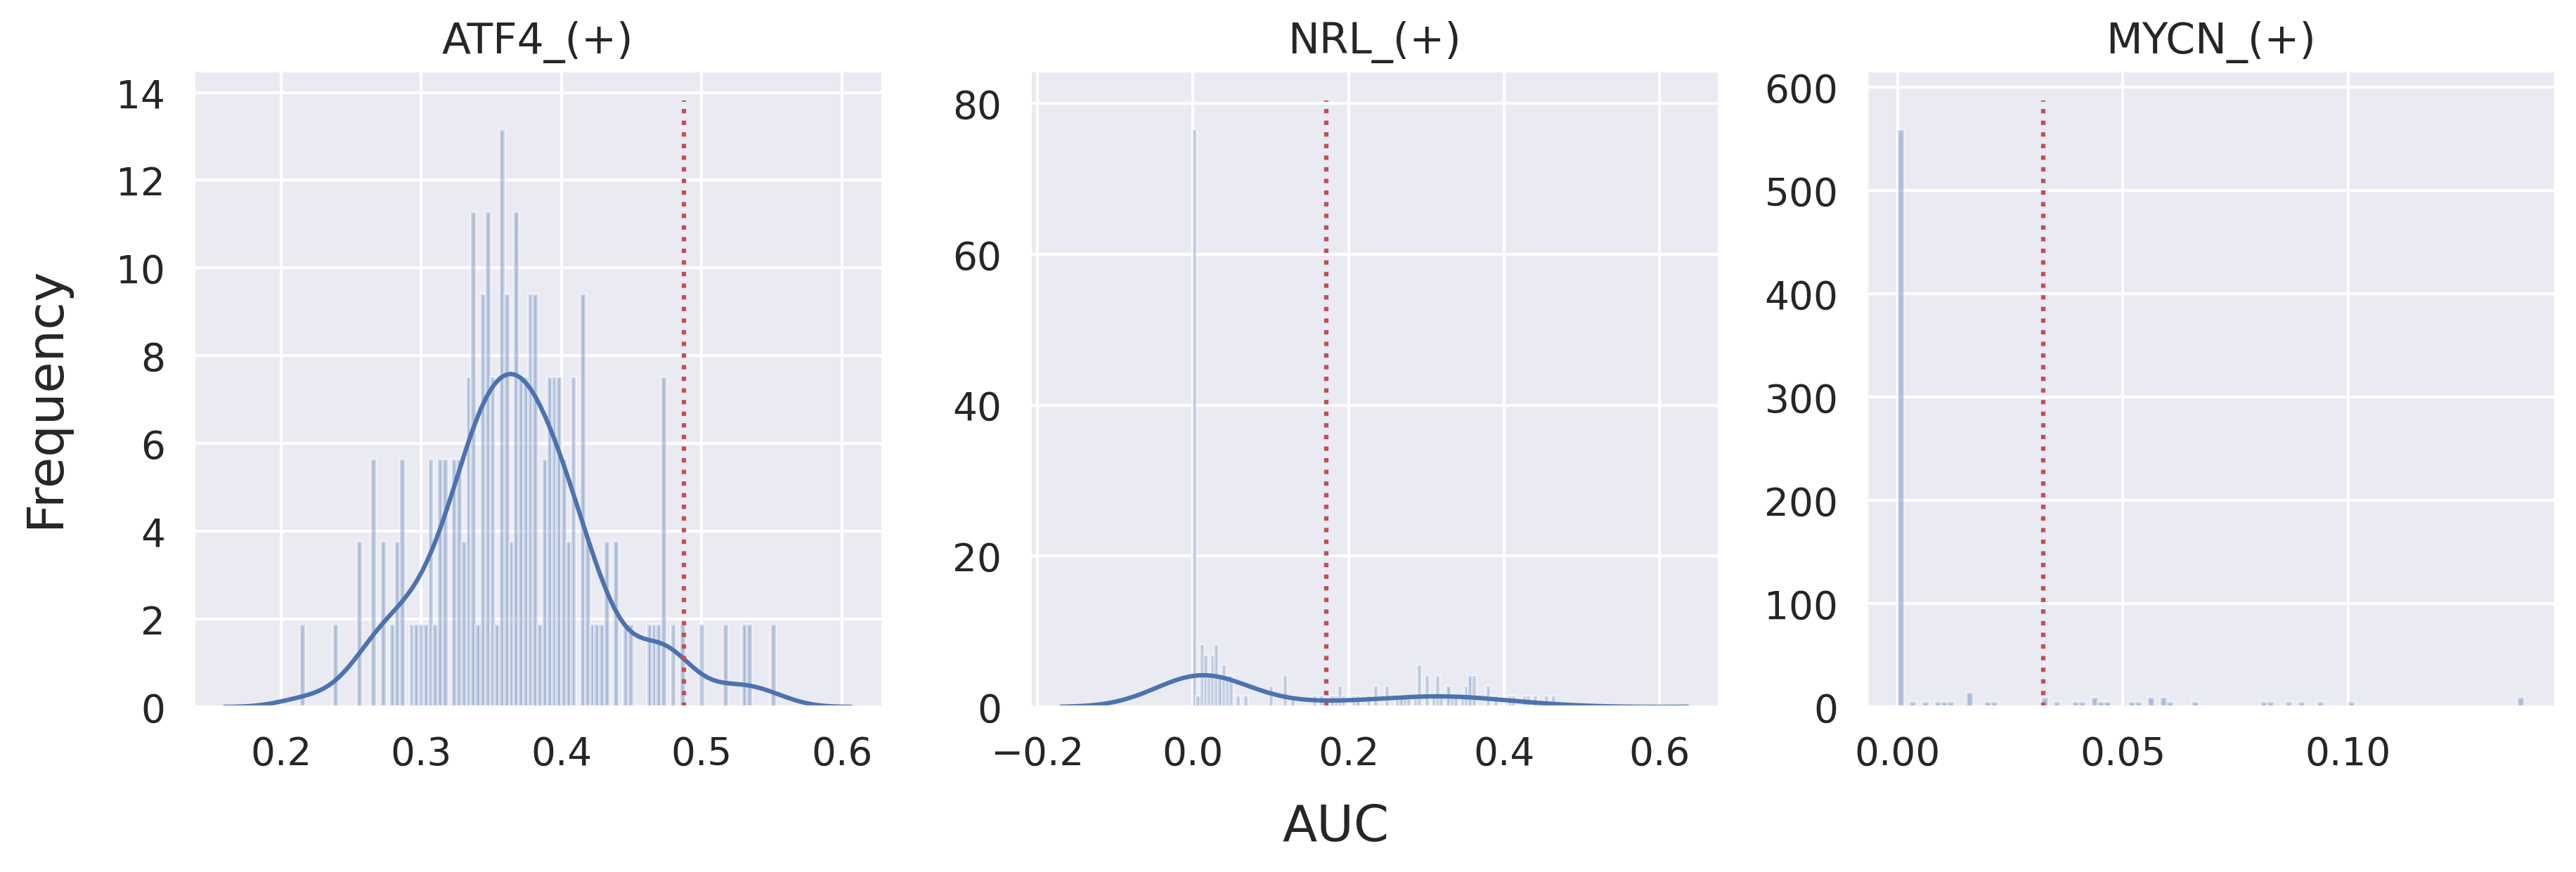

In [249]:
# select regulons:
r = [ 'ATF4_(+)', 'NRL_(+)', 'MYCN_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('output/scenic/scenic-binaryPlot.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [250]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [251]:
adata_h5ad.obs

orig.ident    nCount_RNA  nFeature_RNA     day treatment_group index_i7  \
X41         X41  4.647595e+06          8230   day_3           sh733     N706   
X45         X45  4.971282e+06          9689   day_3           sh733     N706   
X46         X46  3.789641e+06          8869   day_3           sh733     N706   
X48         X48  4.778780e+06         10941   day_3           sh733     N706   
X49         X49  5.190647e+06         11166   day_3           sh733     N707   
...         ...           ...           ...     ...             ...      ...   
X361       X361  4.632972e+06         11227   day_9           sh737     N711   
X409       X409  3.691757e+06          8483  day_12           sh733     N719   
X418       X418  4.237314e+06          8614  day_12           sh733     N720   
X453       X453  4.240182e+06         10675  day_12           sh737     N724   
X512       X512  5.251097e+06         10720  day_15           sh733     N704   

      i7_bases index_i5  i5_bases  lane  ... HMGN3_(+)  JUND_(+) KDM5B_(+)  \
X41   TAGGCATG     S502  ATAGAGAG   2.0  ...  0.695751  0.085849  0.122575   
X45   TAGGCATG     S507  TACTCCTT   2.0  ...  0.780788  0.148162  0.156995   
X46   TAGGCATG     S508  AGGCTTAG   2.0  ...  0.697057  0.079073  0.125888   
X48   TAGGCATG     S511  CGGAGAGA   2.0  ...  0.865485  0.081920  0.105636   
X49   CTCTCTAC     S502  ATAGAGAG   2.0  ...  0.820041  0.061350  0.116946   
...        ...      ...       ...   ...  ...       ...       ...       ...   
X361  AAGAGGCA     S505  CTCCTTAC   6.0  ...  0.779652  0.088897  0.101619   
X409  GCGTAGTA     S505  CTCCTTAC   6.0  ...  0.629232  0.147961  0.125148   
X418  CGGAGCCT     S506  TATGCAGT   6.0  ...  0.603215  0.154377  0.172446   
X453  ACTGAGCG     S510  ATTAGACG   4.0  ...  0.819530  0.057340  0.098709   
X512  TCCTGAGC     S515  AGCTAGAA   5.0  ...  0.778516  0.068046  0.129714   

      MYCN_(+) NFE2L2_(+) NR2F6_(+)   NRL_(+)   RAX_(+)  RORA_(+)  ZNF639_(+)  
X41   0.000000   0.283004  0.194138  0.208297  0.559509  0.060668    0.000000  
X45   0.094297   0.377357  0.298978  0.184731  0.446080  0.105999    0.000000  
X46   0.000000   0.297660  0.196864  0.273736  0.361418  0.183197    0.110020  
X48   0.000000   0.281072  0.197955  0.101373  0.650988  0.228698    0.029584  
X49   0.082368   0.225858  0.241990  0.000000  0.633538  0.207226    0.000000  
...        ...        ...       ...       ...       ...       ...         ...  
X361  0.000000   0.256817  0.425903  0.060181  0.569052  0.225119    0.074029  
X409  0.000000   0.392354  0.196592  0.351690  0.153783  0.351738    0.069939  
X418  0.000000   0.479436  0.197682  0.227529  0.343967  0.000000    0.004908  
X453  0.044308   0.235571  0.256033  0.025903  0.460532  0.264656    0.089434  
X512  0.000000   0.285106  0.199727  0.034327  0.503204  0.073108    0.046489  

[157 rows x 31 columns]

In [252]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

In [283]:
adata_pca = pd.read_csv("output/scenic/martin_pc_output.csv", index_col = 0)
adata_pca

1          2          3          4          5          6  \
X108   0.873020 -12.721486  -0.325460  14.106707 -21.839247  12.401162   
X109  10.840241 -15.206226   1.357469 -14.810697   2.645618  14.914714   
X110 -19.828836 -18.595686  14.277158  -6.051873 -13.208516  16.600911   
X111  24.955043 -22.122746  17.795515  15.843827   5.050140  -2.538142   
X112  13.118467  -7.640759  11.272689  -5.050775 -17.284644 -12.650461   
...         ...        ...        ...        ...        ...        ...   
X78   51.349676 -12.673233 -15.190145 -11.453399   1.088718 -17.316258   
X79   42.053168 -12.971528 -16.030952 -16.489032   9.906961   1.438538   
X82  -13.964377 -19.647414  -1.328610  -3.424006 -24.704380  12.120819   
X83   18.132591 -35.901464  -6.090797  12.788507  -3.249136  -5.492068   
X85   25.785567 -21.519337  -1.925971  -1.735398 -11.836336  -2.091186   

              7          8          9         10         11         12  \
X108  10.503999 -17.742106  17.712895  -6.274862 -30.088492  29.089194   
X109   3.482755   0.545224  -0.423140   0.067799   0.440087  -1.389072   
X110   7.394685   0.254216 -16.510703   2.060448  17.668923  10.542829   
X111  15.558785 -30.706708  -6.203651  11.683024   1.148833  -6.550263   
X112   6.464855   5.178937  -7.257570  15.769019  -9.752310   9.053602   
...         ...        ...        ...        ...        ...        ...   
X78    0.246593  -5.311656  13.601551   4.491182   3.985169  -0.331217   
X79   -9.155243  -0.302187  11.308591   5.824939   0.097660  -1.265426   
X82    8.161264  15.361638  -4.228356  -9.553730  -9.907442  21.349961   
X83   24.629443 -13.135421  -0.584664   2.032823   1.513158 -12.776061   
X85    6.747560   2.097618 -12.307213   8.053887   3.743904   0.621442   

             13         14         15         16         17         18  \
X108  -1.710615  19.499066 -12.335934  56.809554  19.603411 -37.450026   
X109  17.313812   1.962059  -2.028446  -8.290548   3.689760 -14.956871   
X110  -8.457423  -6.386715   7.105628  -0.994255  -0.800013 -13.668203   
X111  -6.651108  -4.033595   7.993120 -11.878926 -26.708855  -8.995833   
X112  13.908164  15.369344  10.048148  -3.798407   1.059421   8.018345   
...         ...        ...        ...        ...        ...        ...   
X78    0.931155   1.299714  -1.405224   5.435630   1.363153  -2.317721   
X79   -5.564216  -3.555729  -6.227207   1.354678  -0.385110   3.310905   
X82   -6.696083   9.685895 -25.022769 -22.431581 -28.391002  24.777068   
X83  -12.235335 -13.512416  -5.552925 -17.197799 -20.616072  -4.462885   
X85    0.475484 -12.129231 -11.839547  13.149066  -4.466902   9.522894   

             19         20  
X108   8.153091  18.832069  
X109  -9.029420   6.983310  
X110   8.092178   4.458131  
X111 -10.872142  15.356412  
X112 -19.957475  17.220899  
...         ...        ...  
X78    0.694367 -10.608424  
X79   -4.470222  -3.977938  
X82   24.897232   4.679678  
X83    2.156422   1.661514  
X85  -17.071258 -18.153719  

[260 rows x 20 columns]

In [302]:
myindex = adata_h5ad.obs.index
adata_pca0 = adata_pca.loc[myindex,]
adata_pca = adata_pca0.to_numpy()

In [363]:
# pd.DataFrame(adata_h5ad.obsm['X_pca']).shape
adata_h5ad.obsm['X_pca'][:,:20] = adata_pca

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


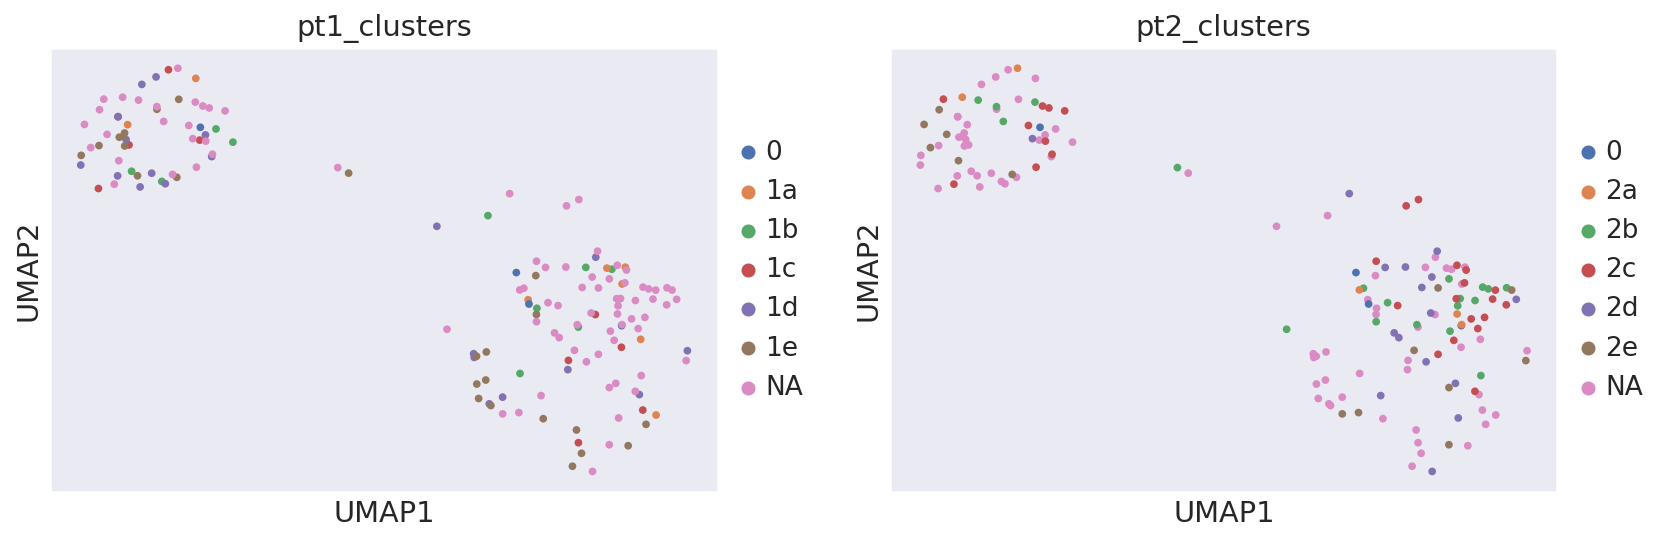

In [365]:
adata_h5ad.obs.columns
sc.pl.umap(adata_h5ad, color=['pt1_clusters', 'pt2_clusters'], size=60, save='.pdf')

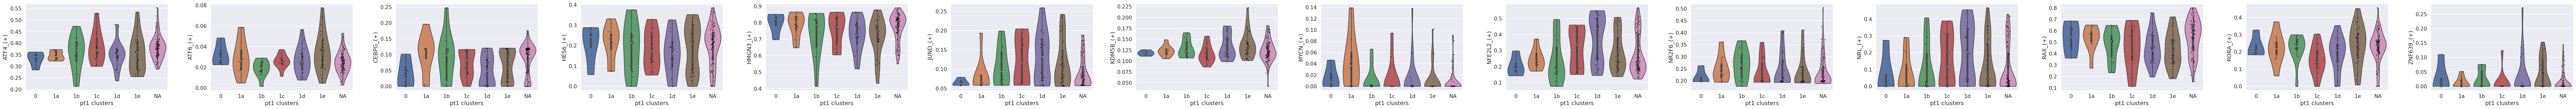

In [418]:
adata_h5ad.obs.pt1_clusters

sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt1_clusters", log=False, stripplot=True, size = 2, inner = "box")

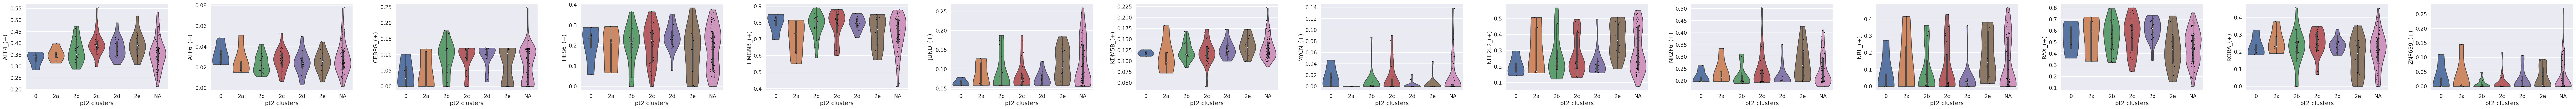

In [419]:
sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="pt2_clusters", log=False, stripplot=True, size = 2, inner = "box")

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


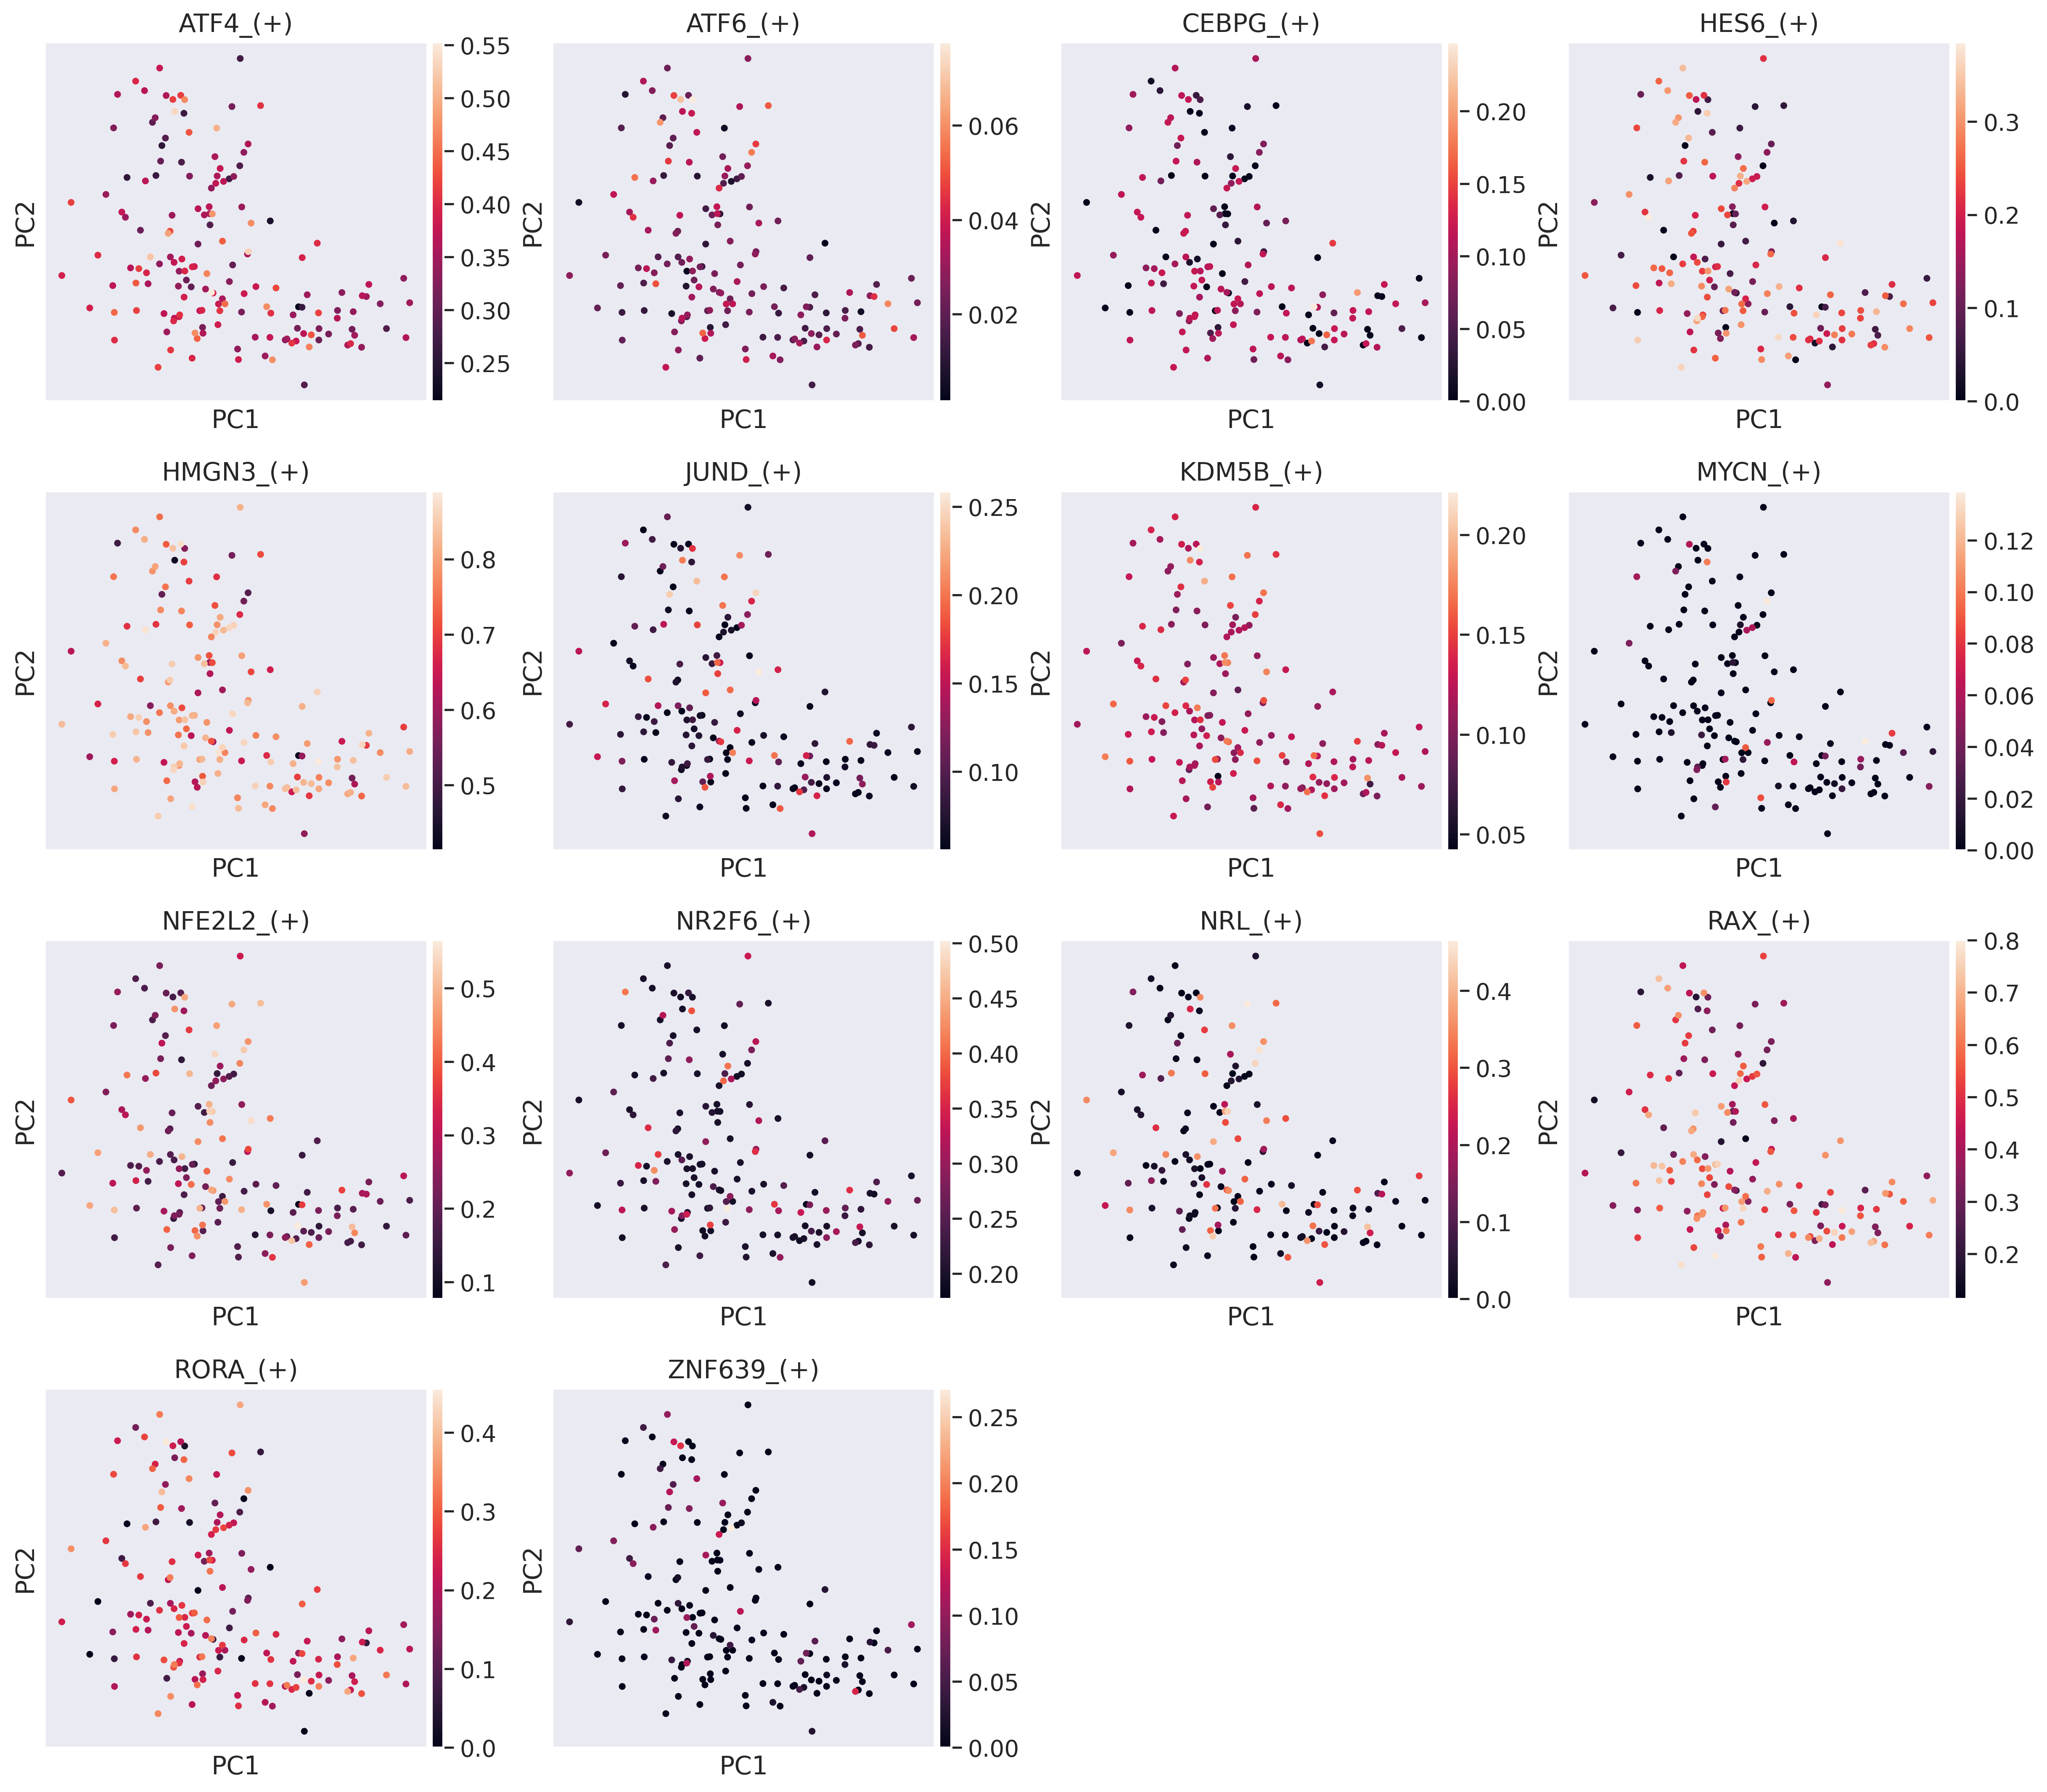

In [308]:
sc.pl.pca(adata_h5ad, components = ['1,2'], color=auc_mtx.columns, size=60, save='.pdf')

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


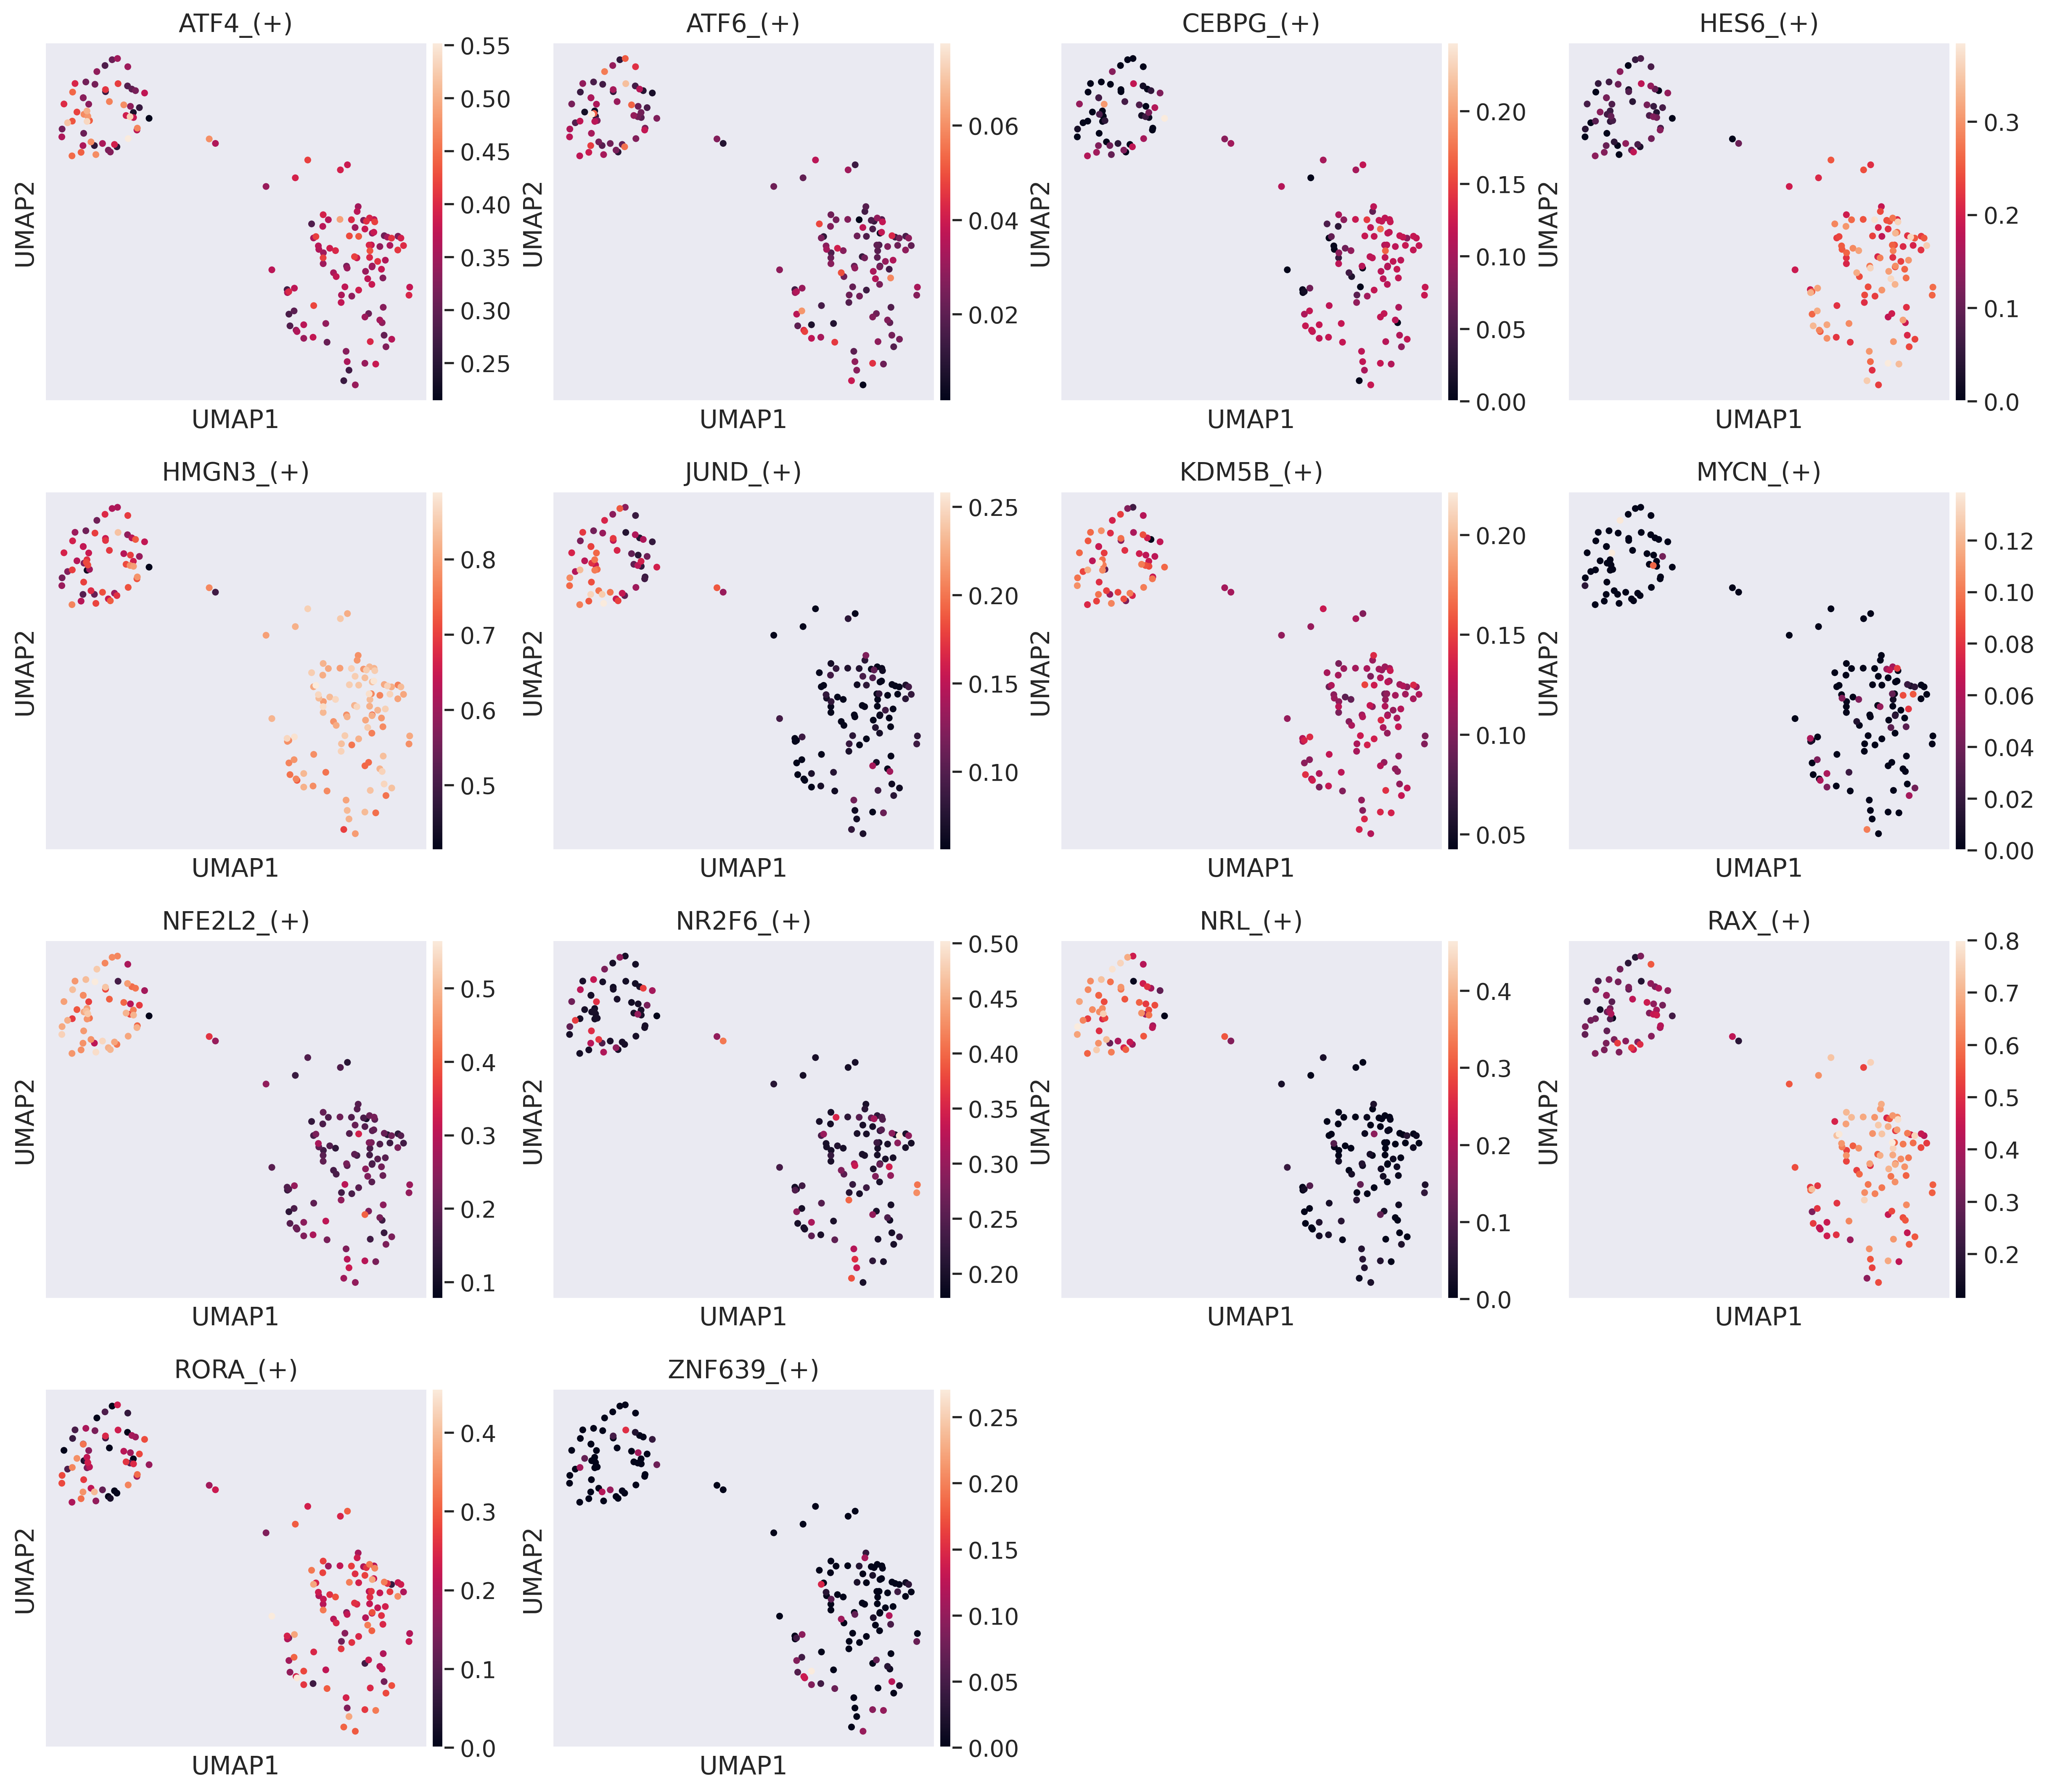

In [186]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')